## Template Matching and Edge Detection Feature Sets

This notebook includes functions and the pipeline for pulling edges and template matching statistics as features

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import cv2
from glob import glob
import pickle

ModuleNotFoundError: No module named 'utils'

In [5]:
# mounting to google drive
from google.colab import drive
drive.mount('/content/drive')



#loading data
import pickle

with open('/content/drive/MyDrive/281_final_project_data/augmented_preprocessed_data.pkl', 'rb') as f:
     train_images, train_labels, test_images, test_labels = pickle.load(f)

Mounted at /content/drive


### Adding Canny Edges to the Images

Canny edges can be added as a channel into the images (shape will then become (H, W, 4) instead of (H, W, 3)) and added as an input into the model, or be used in a pipeline to identify contours of facial landmarks (such as eyes, mouth, nose, etc), or sillhouettes, which can be included as feature statistics into the model.

The below function adds the canny filters into the image as an extra channel and outputs the manipulated image into a designated output folder. we can adjust this to output each image individually or some other format for our pipeline, depending on how it fits with the other feature extraction steps.

### Template Matching statistics as Selected Features
One way to use template matching for feature engineering would be to have templates for each facial expression (e.g. raised eyebrows and open mouth for suprise, smile and thinner eyes for happy, etc). The below function gathers similarity metrics between an image and a template and could be implemented into a pipeline for us to gather these summary statistics across all facial expression templates. E.g. min_val, max_val, avg_score, std_score will be gathered for each facial expression and included in our feature set.

One way of getting these templates is to use the training images and get an average face for each emotion class, then apply the canny detection pipeline to each template. This may add more information than a simple smiley face or frowning face. But if we do this should pay close attention to the test statistics as the templates could be overfit to the training data. We should also inspect those average faces to see if this seems feasible


In [12]:


# processing all images and outputing list of canny edges


def process_images_with_edges(images_array, lower_threshold=50, upper_threshold=150, method = 'canny'):
    """
    Applies grayscale conversion (if needed), histogram equalization,
    and Canny edge detection on a numpy array of images.

    Returns:
        np.ndarray: shape (N, H, W) – Canny edge maps
    """
    if not isinstance(images_array, np.ndarray):
        raise TypeError("Input must be a numpy array.")

    # logic for color images, but function can be applied for images without color channel
    if images_array.ndim == 4:
        # RGB/BGR images
        n_images = images_array.shape[0]
        processed = np.zeros(images_array.shape[:3], dtype=np.uint8)

        for i in range(n_images):
            img = images_array[i]

            # ensuring dtype is uint8
            if img.dtype != np.uint8:
                img = img.astype(np.uint8)

            #grayscale
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #histogram equalization
            img_eq = cv2.equalizeHist(img_gray)
            #edge detection
            if method == 'canny':
              edges = cv2.Canny(img_eq, lower_threshold, upper_threshold)
              #adding to processed array
              processed[i] = edges
            if method == 'sobel':
              # Apply Sobel edge detection
              # Sobel in X direction
              sobelx = cv2.Sobel(img_eq, cv2.CV_64F, 1, 0, ksize=5)
              # Sobel in Y direction
              sobely = cv2.Sobel(img_eq, cv2.CV_64F, 0, 1, ksize=5)
              # Combine both gradients
              sobel_combined = cv2.magnitude(sobelx, sobely)
              sobel_norm = np.uint8((sobel_combined / np.max(sobel_combined)) * 255) if np.max(sobel_combined) > 0 else sobel_combined
              processed[i] = sobel_norm

    elif images_array.ndim == 3:
        # grayscale
        n_images = images_array.shape[0]
        processed = np.zeros(images_array.shape, dtype=np.uint8)

        for i in range(n_images):
            img = images_array[i]

            # ensuring dtype is uint8
            if img.dtype != np.uint8:
                img = img.astype(np.uint8)

            #histogram equalization
            img_eq = cv2.equalizeHist(img)

            if method == 'canny':
              edges = cv2.Canny(img_eq, lower_threshold, upper_threshold)
              #adding to processed array
              processed[i] = edges
            if method == 'sobel':
              # Apply Sobel edge detection
              # Sobel in X direction
              sobelx = cv2.Sobel(img_eq, cv2.CV_64F, 1, 0, ksize=5)
              # Sobel in Y direction
              sobely = cv2.Sobel(img_eq, cv2.CV_64F, 0, 1, ksize=5)
              # Combine both gradients
              sobel_combined = cv2.magnitude(sobelx, sobely)
              processed[i] = sobel_combined


    return processed







# creating emotion expression templates from training data

def create_average_template(images, labels, method = "grayscale"):
    """
    Creates an average face for all images for each emotion class,
    then applies Canny edge detection. Returns a dictionary of templates.
    """

    emotion_dict = {}
    unique_labels = set(labels)

    for lab in unique_labels:
        # selecting and preprocessing all images with the current label
        float_images = []
        for img, label in zip(images, labels):
            if label == lab:
                # ensuring uint8 type before cv functions
                if img.dtype != np.uint8:
                    img = img.astype(np.uint8)

                #grayscale
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                #histogram equalization
                eq = cv2.equalizeHist(gray)
                #appending to list
                float_images.append(eq.astype(np.float32))

        # Compute the average image
        avg_img = np.mean(float_images, axis=0)

        # Clip to valid image range and convert to uint8
        avg_img_uint8 = np.clip(avg_img, 0, 255).astype(np.uint8)

        if method == "grayscale":
          emotion_dict[lab] = avg_img_uint8

        elif method == "canny":
           emotion_dict[lab] = cv2.Canny(avg_img_uint8, 50, 150)

        elif method == "sobel":
           img_edges = cv2.Canny(avg_img_uint8, 50, 150)
           # Apply Sobel edge detection
           # Sobel in X direction
           sobelx = cv2.Sobel(avg_img_uint8, cv2.CV_64F, 1, 0, ksize=5)

           # Sobel in Y direction
           sobely = cv2.Sobel(avg_img_uint8, cv2.CV_64F, 0, 1, ksize=5)

           # Combine both gradients
           sobel_combined = cv2.magnitude(sobelx, sobely)

           emotion_dict[lab] = sobel_combined

    return emotion_dict













def extract_expression_match_features_batch(images, labels, emotion_templates, method = 'default'):
    """
    Takes a numpy array of images and labels, and a dict of preprocessed emotion templates.
    Returns:
        - A list of feature vectors (one per image).
        - A list of corresponding labels.
    """
    feature_matrix = []
    output_labels = []

    for img, label in zip(images, labels):
        # ensuring image is in uint8 format
        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)

        # convert to grayscale for color imgs
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # equalizing and applying edge detection
        img_eq = cv2.equalizeHist(img)

        if method == "default":
          img_processed = img_eq

        elif method == "canny":
          img_processed = cv2.Canny(img_eq, 50, 150)

        elif method == "sobel":
          # Apply Sobel edge detection
          # Sobel in X direction
          sobelx = cv2.Sobel(img_eq, cv2.CV_64F, 1, 0, ksize=5)

          # Sobel in Y direction
          sobely = cv2.Sobel(img_eq, cv2.CV_64F, 0, 1, ksize=5)

          # Combine both gradients
          img_processed = cv2.magnitude(sobelx, sobely)

        feature_vector = []

        for emotion, template in emotion_templates.items():

            #using cv matchTemplate to map edges to template
            result = cv2.matchTemplate(img_processed, template, cv2.TM_CCOEFF_NORMED)
            #getting vals (just pulling max_val for feature set)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
            #computing avg and std for similarity
            avg_score = np.mean(result)
            std_score = np.std(result)

            #adding to feature array
            feature_vector.extend([max_val, avg_score, std_score])

        feature_matrix.append(np.array(feature_vector))
        output_labels.append(label)

    return feature_matrix, output_labels




In [7]:
# function for plotting face templates
import matplotlib.pyplot as plt



def plot_emotion_templates(templates_dict, label_names_dict):
    num_templates = len(templates_dict)
    cols = 4
    rows = (num_templates + cols - 1) // cols  # ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten()

    for i, (label, template_img) in enumerate(sorted(templates_dict.items())):
        ax = axes[i]
        ax.imshow(template_img, cmap='gray')
        ax.set_title(label_names_dict.get(label, f"Label {label}"))
        ax.axis('off')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# label names dictionary for use below
label_names_dict = {1: 'surprise', 2: 'fear', 3: 'disgust', 4: 'happiness', 5: 'sadness', 6: 'anger', 7: 'neutral'}


## Looking at Average Faces

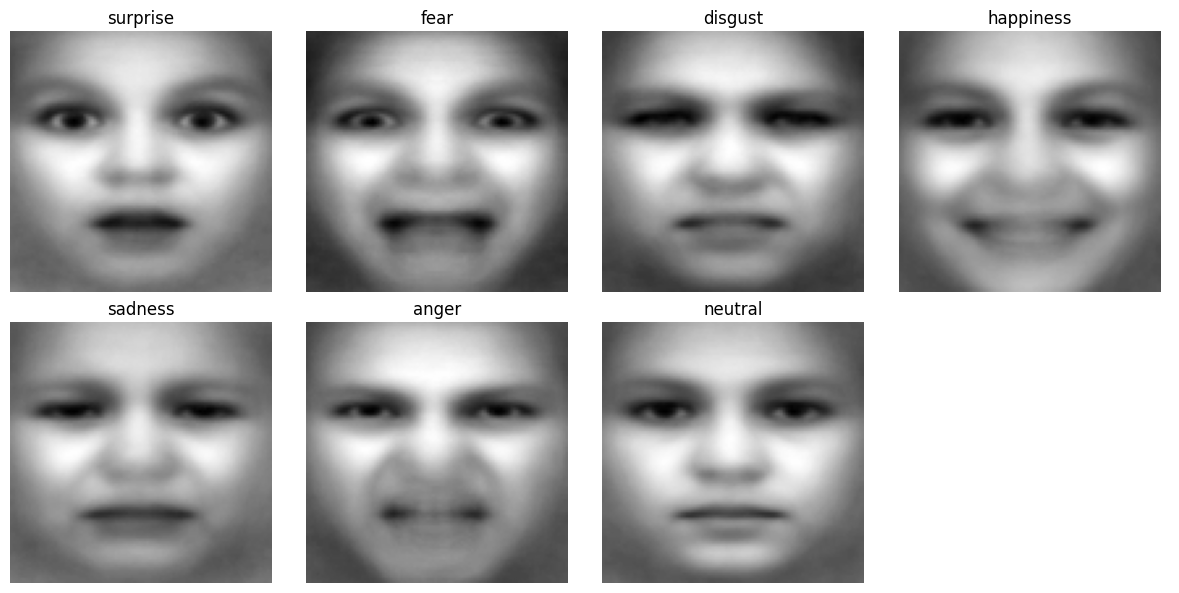

In [ ]:
# grayscale emotion templates
templates_dict_gray = create_average_template(train_images, train_labels)


#actual plotting
plot_emotion_templates(templates_dict_gray, label_names_dict)


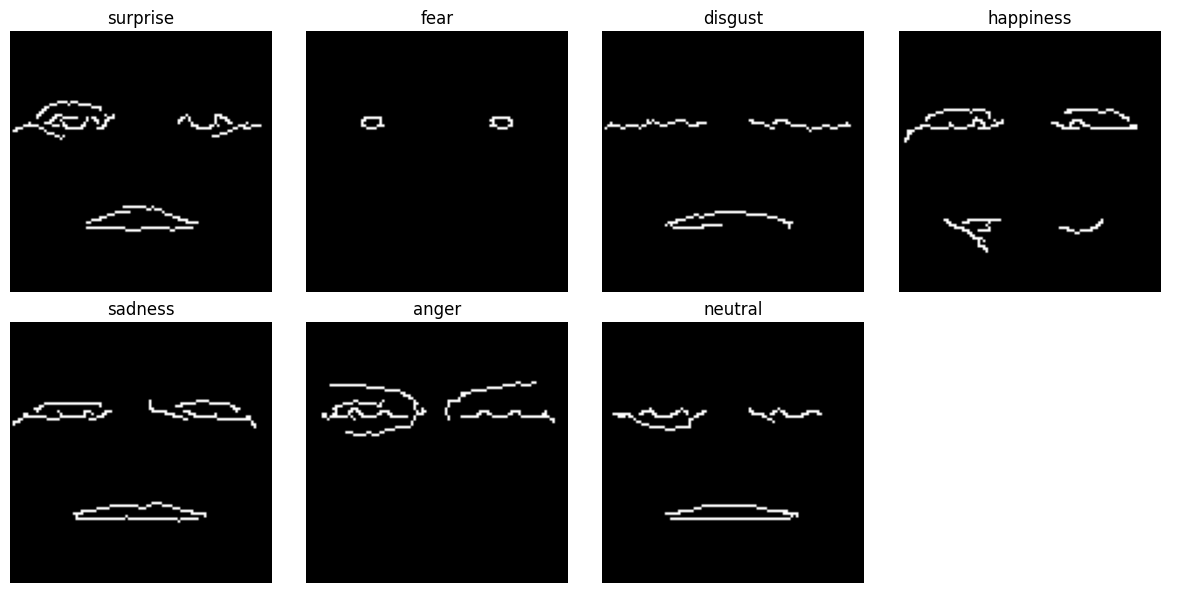

In [ ]:
# canny emotion templates
templates_dict_canny = create_average_template(train_images, train_labels, method = 'canny')


#actual plotting
plot_emotion_templates(templates_dict_canny, label_names_dict)


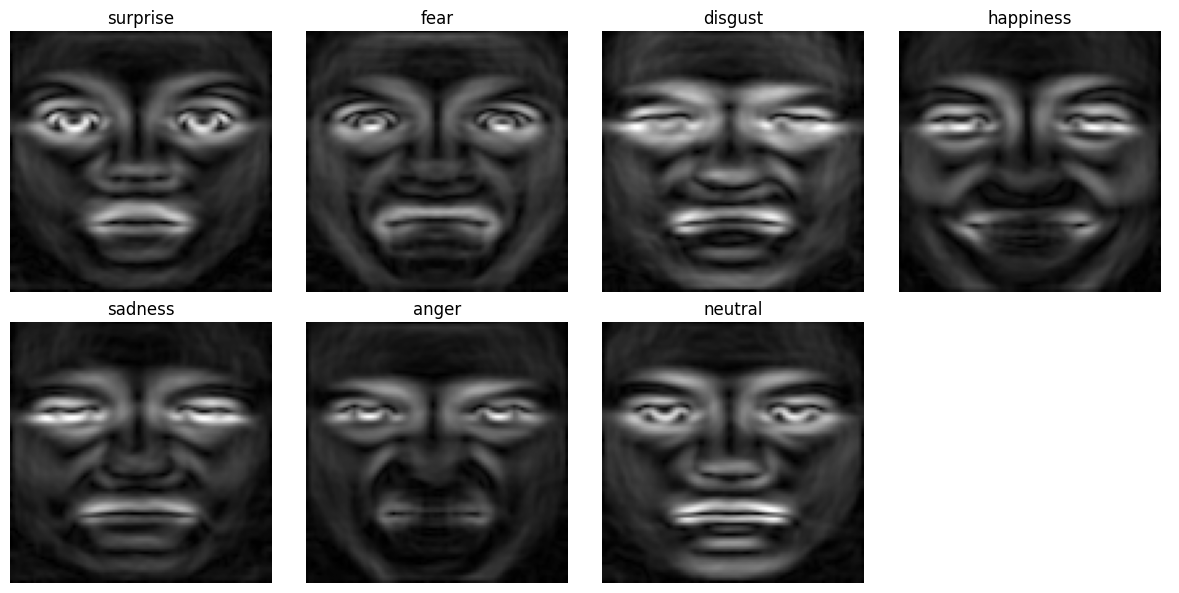

In [ ]:
# sobel emotion templates
templates_dict_sobel = create_average_template(train_images, train_labels, method = 'sobel')


#actual plotting
plot_emotion_templates(templates_dict_sobel, label_names_dict)


## Example Canny and Sobel Images Features

In [13]:

# making function for plotting edge examples
def plot_edge_comparison(images_array, index=0, lower_threshold=50, upper_threshold=150):
    """
    Plots the original image, Canny edge map, and Sobel edge map for a given index.

    Args:
        images_array (np.ndarray): Shape (N, H, W, 3) or (N, H, W)
        index (int): Index of the image to visualize
        lower_threshold (int): Lower threshold for edge detection
        upper_threshold (int): Upper threshold for edge detection
    """
    original = images_array[index]

    if original.ndim == 2:
        original_disp = original
    else:
        original_disp = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    canny_map = process_images_with_edges(images_array[[index]], lower_threshold, upper_threshold, method='canny')[0]
    sobel_map = process_images_with_edges(images_array[[index]], lower_threshold, upper_threshold, method='sobel')[0]


    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_disp, cmap='gray' if original.ndim == 2 else None)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(canny_map, cmap='gray')
    plt.title("Canny")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sobel_map, cmap='gray')
    plt.title("Sobel")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

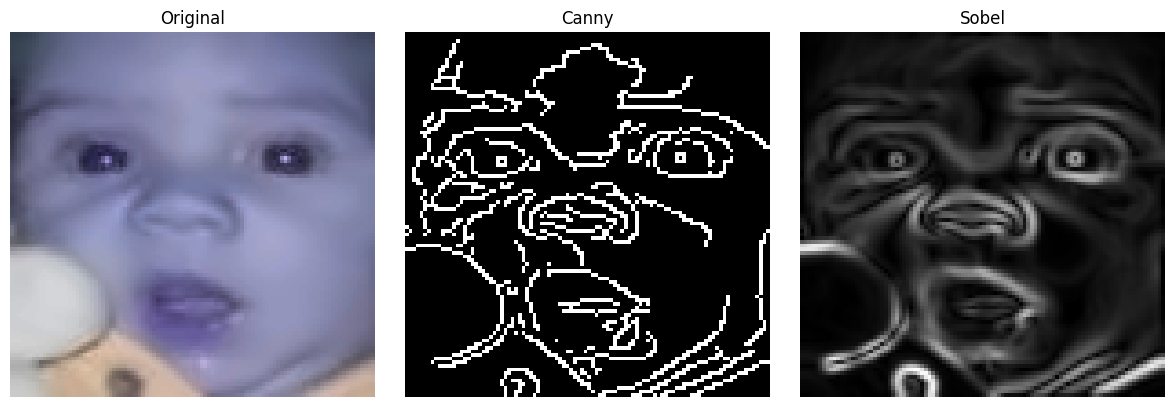

In [14]:
#plotting example images
plot_edge_comparison(train_images)

### Applying Functions to pipeline

In [ ]:


# processing and outputing edges vector
edges_features_2d = process_images_with_edges(train_images)
edges_features_1d = edges_features_2d.reshape(train_images.shape[0], -1) # flattening to just 1d feature vector for each image


# creating emotion templates
templates_dict = create_average_template(train_images, train_labels)


# gathering similarity metrics to add to the feature set
template_match_features, out_labels = extract_expression_match_features_batch(train_images, train_labels, templates_dict)


# final edges and template matching feature set
edge_templ_features = np.concatenate([edges_features_1d, template_match_features], axis=1)



In [ ]:
# sanity check
# showing first few sets of features
edge_templ_features[:5,:]
# this fits, low values for edge detection and higher for similarity metrics


array([[  0.        ,   0.        ,   0.        , ...,   0.37140873,
          0.37140873,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.5478425 ,
          0.5478425 ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.52975285,
          0.52975285,   0.        ],
       [255.        ,   0.        ,   0.        , ...,   0.59033823,
          0.59033823,   0.        ],
       [  0.        ,   0.        , 255.        , ...,   0.36950386,
          0.36950386,   0.        ]])

In [ ]:
# saving feature set into pickle file

# Saving the template matching array
with open('/content/drive/MyDrive/281_final_project_data/basic/Feature/template_match.pkl', 'wb') as f:
    pickle.dump(template_match_features, f)


# Saving the edge array
with open('/content/drive/MyDrive/281_final_project_data/basic/Feature/canny_edges.pkl', 'wb') as f:
    pickle.dump(edges_features_1d, f)


